#### Load and process data

In [1]:
using QuantumACES, StatsBase, LinearAlgebra, DataFrames, GLM, Optim
using Plots, Plots.PlotMeasures, StatsPlots, ColorSchemes, LaTeXStrings, JLD2, PrettyTables
# Set default plot parameters
pgfplotsx()
theme(:default, grid=false, fillalpha=0.5, tick_direction=:out, margins=0px,
    titlefontsize=10, guidefontsize=9, tickfontsize=7, legendfontsize=7)
push!(PGFPlotsX.CUSTOM_PREAMBLE, "\\usepackage{amsmath}")
push!(PGFPlotsX.CUSTOM_PREAMBLE, "\\usepackage{amssymb}")
# :tol_bright is a colourblind-friendly colourscheme
tol_bright = ColorSchemes.tol_bright
colour_series = [tol_bright[3]; tol_bright[1]; tol_bright[2]; tol_bright[4]; tol_bright[5]]
# In REVTeX, one column width is 246 pt, and the text width is 510 pt
col_width = 246.0
text_width = 510.0
aspect_ratio = 4 / 3
inches_per_pt = 1.0 / 72.27
default_dpi = 100.0
col_width_px = col_width * inches_per_pt * default_dpi
text_width_px = text_width * inches_per_pt * default_dpi
col_height_px = col_width_px / aspect_ratio
text_height_px = text_width_px / aspect_ratio
triple_height = (1 + 2 * (text_width / col_width - 1)) * col_width / aspect_ratio
triple_height_px = triple_height * inches_per_pt * default_dpi;

In [2]:
# Initialise data loading parameters
dist = 3
r_1 = 0.075 / 100
r_2 = 0.5 / 100
r_m = 2.0 / 100
total_std_log = sqrt(log(10 / 9))
seed = UInt(0)
ls_type = :wls
unrotated_param = get_unrotated_param(dist)
dep_param = get_dep_param(r_1, r_2, r_m)
log_param = get_log_param(r_1, r_2, r_m, total_std_log; seed=seed)
# Load the metadata
metadata_dict = load("data/design_metadata_$(unrotated_param.circuit_name).jld2")
@assert unrotated_param == metadata_dict["unrotated_param"]
@assert dep_param == metadata_dict["dep_param"]
dep_param_set = metadata_dict["dep_param_set"]
tuple_number_set = metadata_dict["tuple_number_set"]
repeat_numbers_set = metadata_dict["repeat_numbers_set"]
gls_tuple_number = metadata_dict["gls_tuple_number"]
gls_repeat_numbers = metadata_dict["gls_repeat_numbers"]
ols_tuple_number = metadata_dict["ols_tuple_number"]
ols_repeat_numbers = metadata_dict["ols_repeat_numbers"]
dep_param_num = length(dep_param_set)
dep_idx = 14
@assert dep_param == dep_param_set[dep_idx]
merit_data_file = jldopen(
    pwd() *
    "/data/design_merit_data_$(unrotated_param.circuit_name)_$(log_param.noise_name).jld2",
)
expectation_array = merit_data_file["expectation_array"]
dep_worst_idx = findmax(vec(mean(expectation_array; dims = 2)))[2]
repetitions = 400
# Define a rainbow of colours for all of the different designs
rainbow_series = [get(ColorSchemes.gist_rainbow, idx) for idx in 0:0.9/(dep_param_num-1):0.9];

In [3]:
# Calculate the merits and NRMSE pdfs
x_min = 0.0
x_max = 6.0
x_pdf_int = 0.0025
x_values = collect(x_min:x_pdf_int:x_max)
d_set = Vector{Design}(undef, dep_param_num)
merit_set = Vector{Merit}(undef, dep_param_num)
nrmse_pdf_set = Vector{Vector{Float64}}(undef, dep_param_num)
expectation_set = Vector{Float64}(undef, dep_param_num)
variance_set = Vector{Float64}(undef, dep_param_num)
noise_type = :log
if noise_type == :dep
    noise_name = "depolarising"
elseif noise_type == :log
    noise_name = "lognormal"
end
# Calculate the quantities for the WLS optimised designs
for idx in 1:dep_param_num
    d = load_design(unrotated_param, dep_param_set[idx], tuple_number_set[idx], repeat_numbers_set[idx], true, ls_type)
    if noise_type == :dep
        d_set[idx] = update_noise(d, dep_param)
    elseif noise_type == :log
        d_set[idx] = update_noise(d, log_param)
    end
    merit_set[idx] = calc_ls_merit(d_set[idx], ls_type)
    nrmse_pdf_set[idx] = nrmse_pdf(merit_set[idx].eigenvalues, x_values)
    expectation_set[idx] = merit_set[idx].expectation
    variance_set[idx] = merit_set[idx].variance
end
# Calculate the quantities for the GLS and OLS designs
if noise_type == :dep
    d_gls = load_design(unrotated_param, dep_param, gls_tuple_number, gls_repeat_numbers, true, :gls)
    d_wls = load_design(unrotated_param, dep_param_set[dep_idx], tuple_number_set[dep_idx], repeat_numbers_set[dep_idx], true, ls_type)
    d_wls_worst = load_design(unrotated_param, dep_param_set[dep_worst_idx], tuple_number_set[dep_worst_idx], repeat_numbers_set[dep_worst_idx], true, ls_type)
    d_ols = load_design(unrotated_param, dep_param, ols_tuple_number, ols_repeat_numbers, true, :ols)
    @assert d_gls.noise_param == dep_param
    @assert d_wls.noise_param == dep_param
    @assert d_wls_worst.noise_param == dep_param
    @assert d_ols.noise_param == dep_param
elseif noise_type == :log
    d_gls = update_noise(load_design(unrotated_param, dep_param, gls_tuple_number, gls_repeat_numbers, true, :gls), log_param)
    d_wls = update_noise(load_design(unrotated_param, dep_param_set[dep_idx], tuple_number_set[dep_idx], repeat_numbers_set[dep_idx], true, ls_type), log_param)
    d_wls_worst = update_noise(load_design(unrotated_param, dep_param_set[dep_worst_idx], tuple_number_set[dep_worst_idx], repeat_numbers_set[dep_worst_idx], true, ls_type), log_param)
    d_ols = update_noise(load_design(unrotated_param, dep_param, ols_tuple_number, ols_repeat_numbers, true, :ols), log_param)
end
gls_merit = calc_ls_merit(d_gls, :gls)
wls_merit = merit_set[dep_idx]
wls_worst_merit = merit_set[dep_worst_idx]
ols_merit = calc_ls_merit(d_ols, :ols)
gls_nrmse_pdf = nrmse_pdf(gls_merit.eigenvalues, x_values)
wls_nrmse_pdf = nrmse_pdf_set[dep_idx]
wls_worst_nrmse_pdf = nrmse_pdf_set[dep_worst_idx]
ols_nrmse_pdf = nrmse_pdf(ols_merit.eigenvalues, x_values)
gls_expectation = gls_merit.expectation
gls_variance = gls_merit.variance
wls_expectation = wls_merit.expectation
wls_variance = wls_merit.variance
wls_worst_expectation = wls_worst_merit.expectation
wls_worst_variance = wls_worst_merit.variance
ols_expectation = ols_merit.expectation
ols_variance = ols_merit.variance;

┌ Warning: The default singular value decomposition algorithm failed; falling back to QR iteration.
└ @ QuantumACES /Users/evanhockings/.julia/packages/QuantumACES/wgbNB/src/merit.jl:449


#### NRMSE pdfs for all of the different designs for a single random instance of log-normal Pauli noise

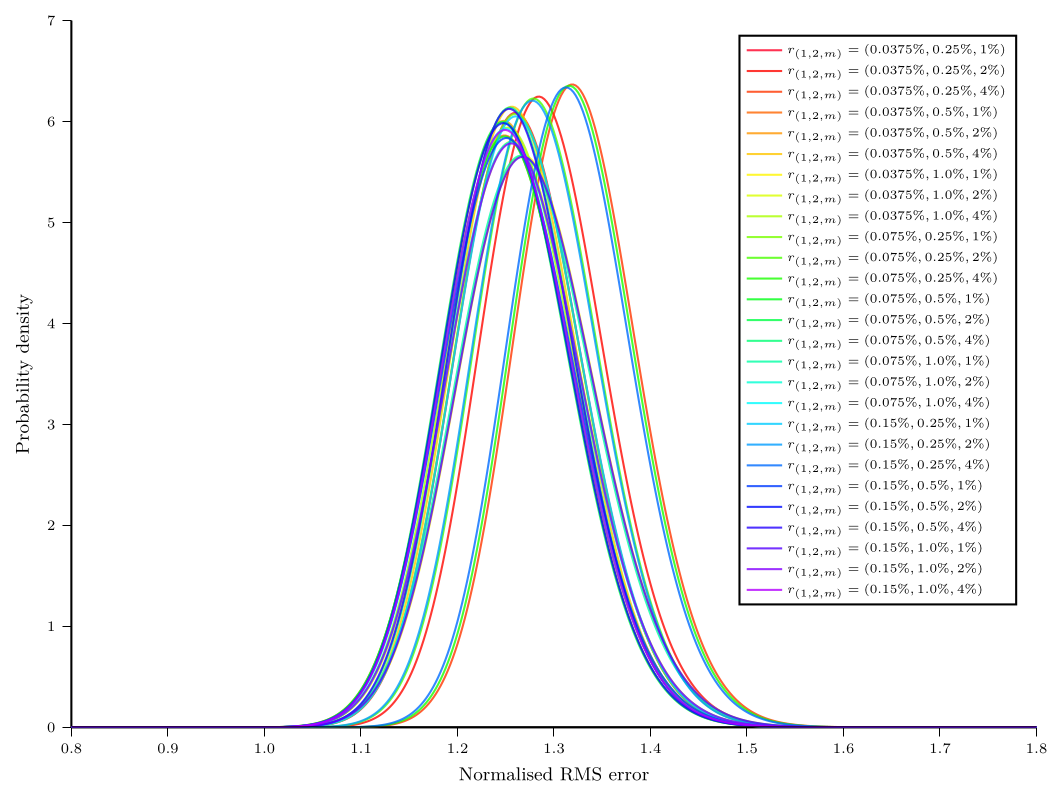

The best design was optimised at: DepolarisingParameters(0.00075, 0.005, 0.02, "depolarising_0.00075_0.005_0.02")
The worst design was optimised at: DepolarisingParameters(0.000375, 0.0025, 0.04, "depolarising_0.000375_0.0025_0.04")


In [4]:
# Plot the NRMSE pdfs for a random instance of log-normal noise for the WLS optimised designs
# Set up plot parameters
x_min = 0.8
x_int = 0.1
x_max = 1.8
y_min = 0.0
y_int = 1.0
y_max = 7.0
x_lims = (x_min, x_max)
x_ticks = x_min:x_int:x_max
x_guide = "Normalised RMS error"
y_lims = (y_min, y_max)
y_ticks = y_min:y_int:y_max
y_guide = "Probability density"
# Create the plot
nrmse_pdfs_plot = plot(; xlims=x_lims, xticks=x_ticks, xguide=x_guide, ylims=y_lims,
    yticks=y_ticks, yguide=y_guide, size=(text_width_px, text_height_px * 1.008),
    legend=:topright, legend_font_halign=:left, legendfontsize=6)
for idx in 1:dep_param_num
    plot!(x_values, nrmse_pdf_set[idx], color=rainbow_series[idx], alpha=0.8,
        label=L"r_{(1,2,m)}=(%$(100*dep_param_set[idx].r_1)\%, %$(100*dep_param_set[idx].r_2)\%, %$(round(Int, 100*dep_param_set[idx].r_m))\%)")
end
plot!([x_min - x_int; x_max + x_int], [y_min; y_min]; color=:black, label=nothing)
savefig(nrmse_pdfs_plot, pwd() * "/figures/nrmse_pdfs_$(unrotated_param.circuit_name)_$(noise_name).pdf")
display(nrmse_pdfs_plot)
println("The best design was optimised at: ", dep_param_set[findmin(expectation_set)[2]])
println("The worst design was optimised at: ", dep_param_set[findmax(expectation_set)[2]])

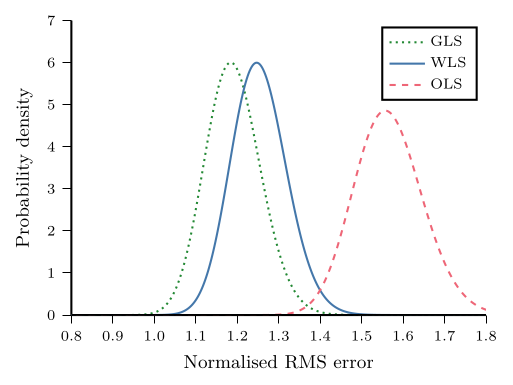

In [5]:
# Plot the NRMSE pdfs for a random instance of log-normal noise for the LS optimised designs
ls_nrmse_pdfs_plot = plot(; xlims=x_lims, xticks=x_ticks, xguide=x_guide, ylims=y_lims, yticks=y_ticks, yguide=y_guide, size=(col_width_px * 0.995, col_height_px * 1.013), legend=:topright, legend_font_halign=:left)
plot!(x_values, gls_nrmse_pdf, color=colour_series[1], linestyle=:dot, label=L"\mathrm{GLS}")
plot!(x_values, nrmse_pdf_set[dep_idx], color=colour_series[2], label=L"\mathrm{WLS}")
plot!(x_values, ols_nrmse_pdf, color=colour_series[3], linestyle=:dash, label=L"\mathrm{OLS}")
plot!([x_min - x_int; x_max + x_int], [y_min; y_min]; color=:black, label=nothing)
savefig(ls_nrmse_pdfs_plot, pwd() * "/figures/ls_nrmse_pdfs_$(unrotated_param.circuit_name)_$(noise_name).pdf")
display(ls_nrmse_pdfs_plot)

In [6]:
# Load and process the merit data over a range of random instances of log-normal noise
merit_data_dict = load("data/design_merit_data_$(unrotated_param.circuit_name)_$(log_param.noise_name).jld2")
expectation_array = merit_data_dict["expectation_array"]
variance_array = merit_data_dict["variance_array"]
gls_expectation_set = merit_data_dict["gls_expectation_set"]
gls_variance_set = merit_data_dict["gls_variance_set"]
ols_expectation_set = merit_data_dict["ols_expectation_set"]
ols_variance_set = merit_data_dict["ols_variance_set"]
@assert size(expectation_array) == (dep_param_num, repetitions)
@assert size(variance_array) == (dep_param_num, repetitions)
@assert length(gls_expectation_set) == repetitions
@assert length(gls_variance_set) == repetitions
@assert length(ols_expectation_set) == repetitions
@assert length(ols_variance_set) == repetitions
# Process the WLS data
dep_params = ["($(rpad(100 * dep_param_set[idx].r_1, 6,'0')), $(rpad(100 * dep_param_set[idx].r_2, 4, '0')), $(round(Int, 100 * dep_param_set[idx].r_m)))" for idx in 1:27]
dep_params_r_1 = [100*dep_param_set[idx].r_1 for idx in 1:27]
dep_params_r_2 = [100*dep_param_set[idx].r_2 for idx in 1:27]
dep_params_r_m = [100*dep_param_set[idx].r_m for idx in 1:27]
expectation_mean = vec(mean(expectation_array; dims=2))
expectation_sem = vec(std(expectation_array; dims=2)) / sqrt(repetitions)
expectation_cov = cov(expectation_array; dims=2) / repetitions
@assert vec(var(expectation_array; dims=2)) / repetitions ≈ diag(cov(expectation_array; dims=2)) / repetitions
@assert all(expectation_mean .>= expectation_mean[dep_idx])
@assert all(expectation_mean .<= expectation_mean[dep_worst_idx])
# Calculate the relative sample requirements
expectation_ratio_mean = expectation_mean / expectation_mean[dep_idx]
expectation_ratio_sem = expectation_ratio_mean .* sqrt.([(expectation_cov[dep_idx, dep_idx] / expectation_mean[dep_idx]^2) + expectation_cov[idx, idx] / expectation_mean[idx]^2 - 2 * expectation_cov[dep_idx, idx] / (expectation_mean[dep_idx] * expectation_mean[idx]) for idx in 1:27])
sample_requirement_mean = expectation_ratio_mean.^2
sample_requirement_sem = 2 * expectation_ratio_mean .* expectation_ratio_sem
# Process the data
gls_expectation_mean = mean(gls_expectation_set)
gls_expectation_sem = std(gls_expectation_set) / sqrt(repetitions)
wls_expectation_mean = expectation_mean[dep_idx]
wls_expectation_sem = expectation_sem[dep_idx]
wls_worst_expectation_mean = expectation_mean[dep_worst_idx]
wls_worst_expectation_sem = expectation_sem[dep_worst_idx]
ols_expectation_mean = mean(ols_expectation_set)
ols_expectation_sem = std(ols_expectation_set) / sqrt(repetitions)
# Print the expected figures of merit and relative sample efficiencies
header = ["r₁ (%)", "r₂ (%)", "rₘ (%)", "Expected figure of merit", "SEM", "Expected sample requirement", "SEM"]
println("Expected figure of merit, and sample requirment relative to the design optimised at the same average noise strength,
over $(repetitions) trials of log-normal Pauli noise for designs optimised at the specified depolarising noise strengths.")
pretty_table(
    hcat(dep_params_r_1, dep_params_r_2, dep_params_r_m, expectation_mean, expectation_sem, sample_requirement_mean, sample_requirement_sem);
    header = header,
    alignment=:l,
    formatters=(ft_printf("%.4f", 4:5), ft_printf("%.5f", 6:7)),
)

Expected figure of merit, and sample requirment relative to the design optimised at the same average noise strength,
over 400 trials of log-normal Pauli noise for designs optimised at the specified depolarising noise strengths.
┌────────┬────────┬────────┬──────────────────────────┬────────┬─────────────────────────────┬─────────┐
│ r₁ (%) │ r₂ (%) │ rₘ (%) │ Expected figure of merit │ SEM    │ Expected sample requirement │ SEM     │
├────────┼────────┼────────┼──────────────────────────┼────────┼─────────────────────────────┼─────────┤
│ 0.0375 │ 0.25   │ 1.0    │ 1.2662                   │ 0.0012 │ 1.02182                     │ 0.00034 │
│ 0.0375 │ 0.25   │ 2.0    │ 1.2898                   │ 0.0013 │ 1.06016                     │ 0.00065 │
│ 0.0375 │ 0.25   │ 4.0    │ 1.3236                   │ 0.0014 │ 1.11641                     │ 0.00095 │
│ 0.0375 │ 0.5    │ 1.0    │ 1.2548                   │ 0.0012 │ 1.00345                     │ 0.00011 │
│ 0.0375 │ 0.5    │ 2.0    │ 1.2537  

#### Heatmapping the expected relative sample efficiency over random instances of log-normal Pauli noise

From left to right, the single-qubit gate noise is [0.0375, 0.075, 0.15]%.


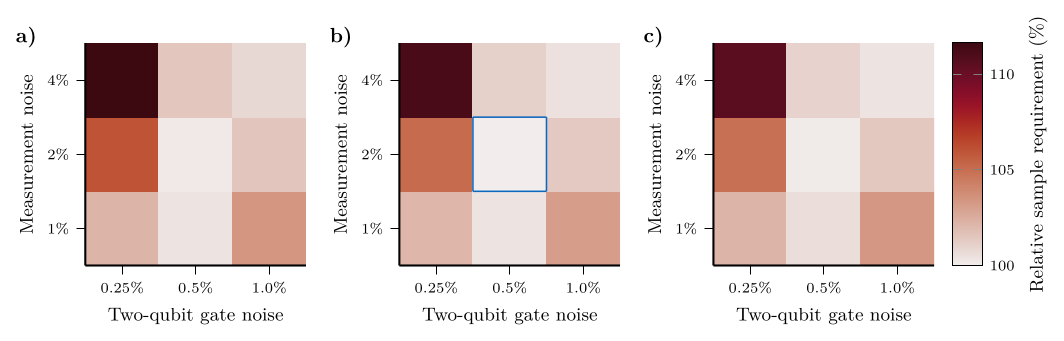

In [7]:
# Heatmaps of the expected relative sample efficiency over random instances of log-normal Pauli noise
# Reshape the data for plotting
tensor_shape = (3,3,3)
dep_param_tensor = reshape(dep_param_set, tensor_shape)
expectation_mean_tensor = reshape(expectation_mean, tensor_shape)
sample_requirement_mean_tensor = reshape(sample_requirement_mean, tensor_shape)
minimum_requirement = minimum(vcat(sample_requirement_mean_tensor...))
maximum_requirement = maximum(vcat(sample_requirement_mean_tensor...))
@assert minimum_requirement ≈ 1.0
# Construct data labels
xlabel = [L"%$(100*dep_param_tensor[1, idx, 1].r_2)\%" for idx in 1:3]
ylabel = [L"%$(convert(Int, 100*dep_param_tensor[idx, 1, 1].r_m))\%" for idx in 1:3]
zlabel = [100*dep_param_tensor[1, 1, idx].r_1 for idx in 1:3]
@assert all([all([dep_param_tensor[i, idx, j].r_2 for i in 1:3, j in 1:3] .== dep_param_tensor[1, idx, 1].r_2) for idx in 1:3])
@assert all([all([dep_param_tensor[idx, i, j].r_m for i in 1:3, j in 1:3] .== dep_param_tensor[idx, 1, 1].r_m) for idx in 1:3])
# Theme the plot
theme(:default, grid=false, fillalpha=1.0, tick_direction=:out, margins=0px,
    titlefontsize=10, guidefontsize=9, tickfontsize=7, legendfontsize=7,
    color=cgrad(:amp), clims=(100, 100 * maximum_requirement),
    colorbar_ticks=(100:5:130), colorbar_title="Relative sample requirement (%)", 
    colorbar_titlefontsize=9, colorbar_tickfontsize=7,
    xlims=(0.5, 3.5), xticks=(1:3, xlabel), xguide="Two-qubit gate noise",
    ylims=(0.5, 3.5), yticks=(1:3, ylabel), yguide="Measurement noise")
# Plot the heatmaps
shot_heatmap_1 = heatmap(100 * sample_requirement_mean_tensor[:, :, 1]; colorbar=false, legend=false,
    extra_kwargs=:plot, add=raw"
    \node[anchor=south west] at (0.0-1.3,0.0-0.2) {\textbf{a)}};
    \node[anchor=south west] at (5.315-1.3,0.0-0.2) {\textbf{b)}};
    \node[anchor=south west] at (2*5.315-1.3,0.0-0.2) {\textbf{c)}};
    ")
# \node at (0.0,0.0) {\textbf{o}};
# \node at (5.315,0.0) {\textbf{o}};
# \node at (2*5.315,0.0) {\textbf{o}};
shot_heatmap_2 = heatmap(100 * sample_requirement_mean_tensor[:, :, 2]; colorbar=false, legend=false)
box_colour = ColorSchemes.balance[48]
box_linewidth = 0.75
plot!([1.5; 1.5], [1.5; 2.5]; color=box_colour, linewidth=box_linewidth)
plot!([2.5; 2.5], [1.5; 2.5]; color=box_colour, linewidth=box_linewidth)
plot!([1.5; 2.5], [1.5; 1.5]; color=box_colour, linewidth=box_linewidth)
plot!([1.5; 2.5], [2.5; 2.5]; color=box_colour, linewidth=box_linewidth)
shot_heatmap_3 = heatmap(100 * sample_requirement_mean_tensor[:, :, 3])
# Plot the combined figure
combined_heatmap = plot(shot_heatmap_1, shot_heatmap_2, shot_heatmap_3; size=(text_width_px * 0.918, col_height_px * 0.825), layout=(1, 3))
println("From left to right, the single-qubit gate noise is $(zlabel)%.")
savefig(combined_heatmap, pwd() * "/figures/expectation_heatmap_$(unrotated_param.circuit_name)_$(noise_name).pdf")
display(combined_heatmap)

#### Design properties

In [8]:
# Display the mean figure of merit for log-normal noise for the LS optimised designs
println("For the GLS optimised design, the expected figure of merit is estimated to be $(round(gls_expectation_mean, digits = 4))±$(round(gls_expectation_sem, digits=4)).")
println("For the WLS optimised design, the expected figure of merit is estimated to be $(round(wls_expectation_mean, digits = 4))±$(round(wls_expectation_sem, digits=4)).")
println("For the OLS optimised design, the expected figure of merit is estimated to be $(round(ols_expectation_mean, digits = 4))±$(round(ols_expectation_sem, digits=4)).")

For the GLS optimised design, the expected figure of merit is estimated to be 1.1902±0.0011.
For the WLS optimised design, the expected figure of merit is estimated to be 1.2527±0.0012.
For the OLS optimised design, the expected figure of merit is estimated to be 1.5637±0.0014.


In [9]:
# Print the WLS optimised design
println("The best WLS optimised design, with $(length(d_wls.tuple_set)) tuples, is: ")
pretty_print(d_wls)

The best WLS optimised design, with 25 tuples, is: 
┌─────────────┬──────────────┬───────────────┐
│ Shot weight │ Tuple        │ Repeat number │
├─────────────┼──────────────┼───────────────┤
│ 0.000480    │ [1]          │ 235           │
│ 0.007555    │ [2]          │ 73            │
│ 0.007590    │ [3]          │ 73            │
│ 0.007592    │ [4]          │ 73            │
│ 0.007557    │ [5]          │ 73            │
│ 0.211805    │ [2]          │ 1             │
│ 0.199083    │ [3]          │ 1             │
│ 0.201937    │ [4]          │ 1             │
│ 0.212692    │ [5]          │ 1             │
│ 0.000283    │ [5, 1, 1]    │ 1             │
│ 0.000305    │ [3, 1, 1]    │ 1             │
│ 0.017920    │ [1, 2]       │ 1             │
│ 0.000212    │ [3, 3, 3, 1] │ 1             │
│ 0.012496    │ [5, 1]       │ 1             │
│ 0.000209    │ [2, 2, 2, 1] │ 1             │
│ 0.000322    │ [1, 1, 4]    │ 1             │
│ 0.025162    │ [4, 1]       │ 1             │
│ 0.0003

In [10]:
# Print the worst WLS optimised design
println("The worst WLS optimised design, with $(length(d_wls_worst.tuple_set)) tuples, is: ")
pretty_print(d_wls_worst)

The worst WLS optimised design, with 33 tuples, is: 
┌─────────────┬─────────────────┬───────────────┐
│ Shot weight │ Tuple           │ Repeat number │
├─────────────┼─────────────────┼───────────────┤
│ 0.000135    │ [1]             │ 529           │
│ 0.002309    │ [2]             │ 145           │
│ 0.002320    │ [3]             │ 145           │
│ 0.002319    │ [4]             │ 145           │
│ 0.002310    │ [5]             │ 145           │
│ 0.210174    │ [2]             │ 1             │
│ 0.201418    │ [3]             │ 1             │
│ 0.201883    │ [4]             │ 1             │
│ 0.213916    │ [5]             │ 1             │
│ 0.000153    │ [2, 2, 1, 2]    │ 1             │
│ 0.000146    │ [5, 1, 5, 5]    │ 1             │
│ 0.000184    │ [5, 1, 1]       │ 1             │
│ 0.000080    │ [1, 4, 4, 1, 4] │ 1             │
│ 0.022343    │ [1, 2]          │ 1             │
│ 0.000193    │ [1, 1, 1, 3]    │ 1             │
│ 0.000145    │ [3, 3, 3, 1]    │ 1            

In [11]:
# Print the GLS optimised design
println("The GLS optimised design, with $(length(d_gls.tuple_set)) tuples, is: ")
pretty_print(d_gls)

The GLS optimised design, with 26 tuples, is: 
┌─────────────┬─────────────────┬───────────────┐
│ Shot weight │ Tuple           │ Repeat number │
├─────────────┼─────────────────┼───────────────┤
│ 0.000572    │ [1]             │ 237           │
│ 0.008308    │ [2]             │ 71            │
│ 0.008416    │ [3]             │ 71            │
│ 0.008414    │ [4]             │ 71            │
│ 0.008310    │ [5]             │ 71            │
│ 0.190638    │ [2]             │ 1             │
│ 0.227754    │ [3]             │ 1             │
│ 0.228825    │ [4]             │ 1             │
│ 0.193037    │ [5]             │ 1             │
│ 0.000246    │ [5, 1, 5, 5]    │ 1             │
│ 0.000719    │ [3, 1, 1]       │ 1             │
│ 0.032461    │ [1, 2]          │ 1             │
│ 0.016995    │ [5, 1, 5, 1]    │ 1             │
│ 0.000500    │ [1, 1, 3]       │ 1             │
│ 0.002759    │ [5, 1]          │ 1             │
│ 0.000482    │ [1, 1, 4]       │ 1             │
│ 0

In [12]:
# Print the OLS optimised design
println("The OLS optimised design, with $(length(d_ols.tuple_set)) tuples, is: ")
pretty_print(d_ols)

The OLS optimised design, with 16 tuples, is: 
┌─────────────┬─────────┬───────────────┐
│ Shot weight │ Tuple   │ Repeat number │
├─────────────┼─────────┼───────────────┤
│ 0.010331    │ [1]     │ 15            │
│ 0.084902    │ [2]     │ 7             │
│ 0.082593    │ [3]     │ 7             │
│ 0.082593    │ [4]     │ 7             │
│ 0.082531    │ [5]     │ 7             │
│ 0.015202    │ [1]     │ 1             │
│ 0.080601    │ [2]     │ 1             │
│ 0.078185    │ [3]     │ 1             │
│ 0.078185    │ [4]     │ 1             │
│ 0.078691    │ [5]     │ 1             │
│ 0.017781    │ Int64[] │ 1             │
│ 0.072594    │ [1, 2]  │ 1             │
│ 0.073761    │ [5, 1]  │ 1             │
│ 0.073710    │ [4, 1]  │ 1             │
│ 0.073710    │ [3, 1]  │ 1             │
│ 0.014630    │ [1, 1]  │ 1             │
└─────────────┴─────────┴───────────────┘
